# STA 663 Final Project

## Implementation of Auto-Encoding Variational Bayes

In this file we have the final codes as well as gradient testing, and testing vs basline version to ensure accuracy.

## Final Codes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit

In [2]:
def sigmoid(x):
    """sigmoid function"""
    return 1/(1+np.exp(-x))

def sigmoid_gradient(x):
    """gradient of sigmoid function"""
    return x * (1-x)

def tanh(x):
    """tanh function"""
    return np.tanh(x)
    
def tanh_gradient(x):
    """gradient of tanh function"""
    return 1-np.power(x,2)

In [3]:
def get_Batch(M, trainX, trainy):
    """randomly sample a mini batch of size M from the training data"""
    
    N = trainX.shape[0]
    sample = np.random.choice(N,M)
    
    return trainX[sample], trainy[sample]

In [4]:
def init_random(dx, dm, dz, option = "xavier"):
    """
    parameter initialization
    xavier initialization for weights
    all zero for bias
    can be used to initialize all zero variables for ADAM by setting "option = zeros"
    """
    
    # weights initialization
    if option == "zeros":
        # only for variables in ADAM algorithm, not to be used for true model parameters
        q_W1 = np.zeros((dm, dx))
        p_W5 = np.zeros((dx, dm))
        q_W2 = np.zeros((dz, dm))
        q_W3 = np.zeros((dz, dm))
        p_W4 = np.zeros((dm, dz))
    elif option == "xavier":
        bound = np.sqrt(6)/ np.sqrt(dx + dm)
        q_W1 = np.random.uniform(-bound, bound, (dm, dx))
        p_W5 = np.random.uniform(-bound, bound, (dx, dm))
        bound = np.sqrt(6)/ np.sqrt(dm + dz)
        q_W2 = np.random.uniform(-bound, bound, (dz, dm))
        q_W3 = np.random.uniform(-bound, bound, (dz, dm))
        p_W4 = np.random.uniform(-bound, bound, (dm, dz))
    
    # bias initialization
    q_b1 = np.zeros((dm, 1))
    p_b5 = np.zeros((dx, 1))
    q_b2 = np.zeros((dz, 1))
    q_b3 = np.zeros((dz, 1))
    p_b4 = np.zeros((dm, 1))
    
    W = [q_W1, q_W2, q_W3, p_W4, p_W5]
    b = [q_b1, q_b2, q_b3, p_b4, p_b5]
    
    return W, b

In [5]:
def encoder_forward_vec(X, W, b):
    """
    encoder forward propagation - vectorized version
    X: M by dx
    q_h1.T: M by dm
    q_a2.T: M by dz
    q_mu.T: M by dz
    q_s2.T: M by dz
    
    """
    
    q_W1, q_W2, q_W3, d,d = W
    q_b1, q_b2, q_b3, d,d = b
    
    q_a1 = q_W1 @ X.T + q_b1 # dm by M
    q_h1 = tanh_nb(q_a1) # dm by M
    q_mu = q_W2 @ q_h1 + q_b2 # dz by M
    q_a2 = q_W3 @ q_h1 + q_b3 # dz by M
    q_s2 = np.exp(q_a2) # dz by M
    
    return q_h1.T, q_a2.T, q_mu.T, q_s2.T

In [6]:
def sample_z_vec(q_mu, q_s2, eps):
    """sample latent variable z - vectorized version"""
    
    M, dz = q_mu.shape 

    return q_mu.reshape(M,1,dz) + np.sqrt(q_s2).reshape(M,1,dz) * eps # M by L by dz

In [7]:
def decoder_forward_vec(W, b, z):
    """
    decoder forward propagation - vectorized version
    z: M by L by dz
    """
    
    d,d,d, p_W4, p_W5 = W
    d,d,d, p_b4, p_b5 = b
    
    p_a3 = z @ p_W4.T + p_b4.T # M by L by dm
    p_h2 = tanh_nb(p_a3) # M by L by dm
            
    p_a4 = p_h2 @ p_W5.T + p_b5.T # M by L by dx
    y = sigmoid_nb(p_a4) # M by L by dx
    
    return y, p_h2

In [8]:
def total_loss_vec(X, y, q_a2, q_mu, q_s2):
    """target total loss function - to minimize - vectorized version"""
    
    M, dx, L = X.shape[0], X.shape[1], y.shape[1]
    
    # reconstruction loss for each sample of latent variable
    loss = -np.sum(X.reshape(M,1,dx) * np.log(y) + (1-X.reshape(M,1,dx))* np.log(1-y)) / L
    
    # KL divergence/ regularization
    loss = (loss + np.sum(np.power(q_mu,2) + q_s2 - q_a2 - 1)/2)/M
    
    return loss

In [9]:
def para_update(W, b, dW, db, alpha):
    """update weights and bias for gradient descent"""
    
    assert len(W) == len(b) == len(dW) == len(db)
    n = len(W)
    
    for i in range(n):
        W[i] = W[i] - alpha * dW[i]
        b[i] = b[i] - alpha * db[i]
    
    return W, b

In [10]:
sigmoid_nb = jit(sigmoid, nopython=True, cache=True)
sigmoid_gradient_nb = jit(sigmoid_gradient, nopython=True, cache=True)
tanh_nb = jit(tanh, nopython=True, cache=True)
tanh_gradient_nb = jit(tanh_gradient, nopython=True, cache=True)
get_Batch_nb = jit(get_Batch, nopython=True)
init_random_nb1 = jit(init_random, nopython=True)
sample_z_vec_nb = jit(sample_z_vec, nopython=True, cache=True)
encoder_forward_vec_nb1 = jit(encoder_forward_vec, nopython=True, cache=True)
decoder_forward_vec_nb1 = jit(decoder_forward_vec, cache=True)
total_loss_vec_nb = jit(total_loss_vec, nopython=True, cache=True)
para_update_nb = jit(para_update, nopython=True, cache=True)

In [11]:
@jit(cache=True)
def batch_forward_vec_nb2(Spec, X, W, b, eps):
    """forward propagation for one mini batch - full vectorized version"""
    d, M, L, d, dx, dm, dz, d, d = Spec

    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    q_h1, q_a2, q_mu, q_s2 = encoder_forward_vec_nb1(X, W, b) # M by dm, M by dz, M by dz, M by dz
    z = sample_z_vec_nb(q_mu, q_s2, eps)
    y, p_h2 = decoder_forward_vec_nb1(W, b, z)
    
    loss = total_loss_vec_nb(X, y, q_a2, q_mu, q_s2)

    return y, q_h1, p_h2, q_mu, q_s2, z, loss

In [12]:
@njit(cache=True)
def grad_vec2_nb3(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps):
    """"
    batch gradient calculation - vectorized version
    not using lists for parameters to enable numba nopython
    
    inputs:
        X: Data [M by dx]
        y: Model results [M by L by dx]
        q_W1 (dm by dx), q_W2 (dz by dm), q_W3 (dz by dm): Weights for encoder
        p_W4 (dm by dz), p_W5 (dx by dm): Weights for decoder
        q_b1, q_b2, q_b3: Bias for encoder
        p_b4, p_b5: Bias for decoder
        q_h1 (M by dm), p_h2 (M by L by dm): intermediate activation variables
        eps (M by L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz): for sampling latent variables from posterior
    """
    
    M, L, d = y.shape
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)

    # back propagation for loss
    for iL in range(L):
        y_iL = y[:,iL,:] # M by dx
        p_h2_iL = p_h2[:,iL,:] # M by dm
        z_iL = z[:,iL,:] # M by dz
        
        L_d4 = y_iL - X # M by dx
        dL_dW5 = dL_dW5 + L_d4.T @ p_h2_iL # dx by dm
        dL_db5 = dL_db5 + np.sum(L_d4, axis = 0).reshape(-1,1) # dx by 1
        
        L_d3 = L_d4 @ p_W5 * tanh_gradient_nb(p_h2_iL) # M by dm
        dL_dW4 = dL_dW4 + L_d3.T @ z_iL # dm by dz
        dL_db4 = dL_db4 + np.sum(L_d3, axis = 0).reshape(-1,1) # dm by 1
        
        L_d22 = L_d3 @ p_W4 * eps[:,iL,] * np.sqrt(q_s2) / 2  # M by dz
        dL_dW3 = dL_dW3 + L_d22.T @ q_h1 # dz by dm
        dL_db3 = dL_db3 + np.sum(L_d22, axis = 0).reshape(-1,1) # dz by 1
        
        L_d21 = L_d3 @ p_W4 # M by dz
        dL_dW2 = dL_dW2 + L_d21.T @ q_h1 # dz by dm
        dL_db2 = dL_db2 + np.sum(L_d21, axis = 0).reshape(-1,1) # dz by 1

        L_d1 = (L_d21 @ q_W2 + L_d22 @ q_W3) * tanh_gradient_nb(q_h1) # M by dm
        dL_dW1 = dL_dW1 + L_d1.T @ X # dm by dx
        dL_db1 = dL_db1 + np.sum(L_d1, axis = 0).reshape(-1,1) # dm by 1

    # back propagation for regularization
    R_d22 = (q_s2 - 1)/2 # M by dz
    dR_dW3 = dR_dW3 + R_d22.T @ q_h1 # dz by dm
    dR_db3 = dR_db3 + np.sum(R_d22, axis = 0).reshape(-1,1) # dz by 1
    
    R_d21 = q_mu # M by dz
    dR_dW2 = dR_dW2 + R_d21.T @ q_h1 # dz by dm
    dR_db2 = dR_db2 + np.sum(R_d21, axis = 0).reshape(-1,1) # dm by 1

    R_d1 = (R_d22 @ q_W3 + R_d21 @ q_W2) * tanh_gradient_nb(q_h1) # M by dm
    dR_dW1 = dR_dW1 + R_d1.T @ X # dm by dx
    dR_db1 = dR_db1 + np.sum(R_d1, axis = 0).reshape(-1,1) # dm by 1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    return dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5

In [19]:
@jit(cache=True)
def train_AEVB(trainX, trainy, nBatch, M = 100, L = 1, std_const = 255, dm = 500, dz = 3, alpha = 0.005, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8, W = "", b = "", loss = "", nP = 0):
    """
    AEVB model as described in the paper
    Diederik P Kingma, Max Welling
    Auto-Encoding Variational Bayes (2013).
    
    Training using ADAM algorithm as described in the paper
    Diederik P Kingma, Jimmy Ba
    Adam: A Method for Stochastic Optimization (2014).
    
    Input parameters：
    ----------
    trainX: array_like
            Training dataset inputs.
            Dimension: number of sample by dx
    trainy: array_like
            Training dataset labels. 
            This variable is not currently used in the function. For future developments.
    nBatch: integer
            Number of mini-batch to train.
    M: integer, optional
            Size of mini-batch.
            Default at 100 as recommended in the paper.
    L: integer, optional
            Number of latent variable to sample.
            Default at 1 as recommended in the paper.
    std_const: scalar, optional
            Normlizing constant for data.
            Currently default at 255 which is usually used for black and white image data.
    dm: integer, optional
            Dimension for middle layer of the encoder and decoder.
            Default at 500 which used for MNIST dataset in the paper.
    dz: integer, optional
            Dimension for latent variables. 
            Currently default at 3
    alpha: float, optional
            Learning rate.
            Default at 0.005.
    beta1: float, optional
            Parameter for ADAM.
            Default at 0.9.
    beta2: float, optional
            Parameter for ADAM.
            Default at 0.999.
    eps_stable: float, optional
            Parameter for ADAM.
            Default at 1e-08.
    W: list, optional
            List of model weights parameters, same format as function output variable W.
            In case user wants to start training from existing parameters.
    b: list, optional
            List of model bias parameters, same format as function output variable b.
            In case user wants to start training from existing parameters.
    nP: integer, optional
            If specified with non-zero number, function will print out 
            status message after completing every nP batches.
    
    Returns:
    ----------
    W: list
            List of model weights parameters in the order of: q_W1, q_W2, q_W3, p_W4, p_W5.
            q_W1, q_W2, q_W3: weights for Gaussian MLP encoder as specified in paper Appendix C.
            p_W4, p_W5: weights for Bernoulli MLP decoder as specified in paper Appendix C
    b: list
            List of model bias parameters in the order of q_b1, q_b2, q_b3, p_b4, p_b5.
            q_b1, q_b2, q_b3: bias for Gaussian MLP encoder as specified in paper Appendix C.
            p_b4, p_b5: weights for Bernoulli MLP decoder as specified in paper Appendix C.
    loss: array-like
            Array which stores total loss for each mini-batch.
    """
    
    dx = trainX.shape[1]
    Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]
    
    # initiate parameters for ADAM
    # need to use separate lines of codes otherwise they share the same reference
    v_dW, v_db = init_random_nb1(dx, dm, dz, option = "zeros")
    s_dW, s_db = init_random_nb1(dx, dm, dz, option = "zeros")
    vc_dW, vc_db = init_random_nb1(dx, dm, dz, option = "zeros")
    sc_dW, sc_db = init_random_nb1(dx, dm, dz, option = "zeros")
    num_para = len(v_dW)
    
    # weights and bias initialization
    if len(W) == len(b) == 0:
        W, b = init_random_nb1(dx, dm, dz)

    # loss
    start = len(loss)
    if start == 0:
        loss = np.zeros(nBatch)
    else:
        loss = np.resize(loss, start + nBatch)
    
    for iB in range(start, start + nBatch):
        # sample a random batch
        batchX, batchy = get_Batch_nb(M, trainX, trainy)
        X = batchX.reshape(M, dx) / std_const

        # sample random noise for latent variable
        eps = np.random.randn(M, L, dz)

        y, q_h1, p_h2, q_mu, q_s2, z, loss[iB] = batch_forward_vec_nb2(Spec, X, W, b, eps)

        q_W1, q_W2, q_W3, p_W4, p_W5 = W
        q_b1, q_b2, q_b3, p_b4, p_b5 = b
        
        dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5 =\
        grad_vec2_nb3(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)
        
        dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
        db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
        
        # ADAM
        for i in range(num_para):
            v_dW[i] = beta1*v_dW[i] + (1-beta1)*dW[i]
            v_db[i] = beta1*v_db[i] + (1-beta1)*db[i]
            s_dW[i] = beta2*s_dW[i] + (1-beta2)*np.power(dW[i],2)
            s_db[i] = beta2*s_db[i] + (1-beta2)*np.power(db[i],2)
        
            vc_dW[i] = v_dW[i]/(1-beta1**(iB+1))
            vc_db[i] = v_db[i]/(1-beta1**(iB+1))
            sc_dW[i] = s_dW[i]/(1-beta2**(iB+1))
            sc_db[i] = s_db[i]/(1-beta2**(iB+1))
        
            dW[i] = vc_dW[i] / (np.sqrt(sc_dW[i]) + eps_stable)
            db[i] = vc_db[i] / (np.sqrt(sc_db[i]) + eps_stable)

        W, b = para_update_nb(W, b, dW, db, alpha)
        
        if (nP != 0) and (iB+1) % nP == 0:
            print("Batch " + str(iB+1) + " completed.")

    return W, b, loss

In [22]:
def plot_samples(trainX, trainy, W, b, Xdim1 = 0, fig1="", fig2="", std_const = 255):
    """
    Randomly sample 36 data points from training data, reconstruct the images 
    based on user specified model parameters and plot both for comparison.
    
    Input parameters：
    ----------
    trainX: array_like
            Training dataset inputs.
            Dimension: number of sample by dx.
    trainy: array_like
            Training dataset labels. 
            This variable is not currently used in the function. For future developments.
    W: list
            List of model weights parameters, same format as train_AEVB function output variable W.
    b: list
            List of model bias parameters, same format as train_AEVB function output variable b.
    Xdim1: integer, optional
            Dimension1 for X. If not specified, Xdim1 will be set to = Xdim2 = sqrt(dx).
    fig1: string, optional
            If specified, will save the plot with 36 sampled training data with file name 'fig1'.
    fig2: string, optional
            If specified, will save the plot with 36 reconstructed images with file name 'fig2'.
    std_const: integer, optional
            Normlizing constant to reconstruct data.
            Currently default at 255 which is usually used for black and white image data.            
    
    Output:
    ----------
    Comparison plots between training data and reconstructed images based on 
    36 random sampled data points.
    """
    
    dx = trainX.shape[1]
    if Xdim1 == 0:
        Xdim1 = Xdim2 = int(np.sqrt(dx))
    else:
        Xdim2 = int(dx / Xdim1)
        assert(Xdim2 == int(Xdim2))
        
    M = 36
    n = int(np.sqrt(M))
    L = 1
    dz, dm = W[1].shape[0], W[1].shape[1]
    Spec = [1, M, L, std_const, dx, dm, dz, 0.005, 0]

    batchX, batchy = get_Batch_nb(M, trainX, trainy)
    X = batchX / std_const
    eps = np.zeros((M, L, dz))

    y, q_h1, p_h2, q_mu, q_s2, z, loss = batch_forward_vec_nb2(Spec, X, W, b, eps)
    
    fig, ax = plt.subplots(M)
    #fig.suptitle('Sample Images')
    
    for i in range(M):
        # define subplot
        plt.subplot(n,n,i+1)
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[i].reshape(Xdim1, Xdim2) * std_const, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.axis('off')
    plt.show()
    if fig1 != "":
        fig.savefig(fig1)

    fig, ax = plt.subplots(M)
    #fig.suptitle('Reconstructed Images')
    
    for i in range(M):
        # define subplot
        plt.subplot(n,n,i+1)
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(y[i,L-1,].reshape(Xdim1, Xdim2) * std_const, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()
    if fig2 != "":
        fig.savefig(fig2)

The following is to plot random 9 figures from MNIST dataset based on our own learned parameters.

In [15]:
# load dataset
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle

(trainX_raw, trainy), (testX_raw, testy) = mnist.load_data()

trainX = trainX_raw.reshape(trainX_raw.shape[0],-1)

Using TensorFlow backend.


In [22]:
def save_para(filename, **kwargs):
    """save weights and bias parameters"""
    file = open(filename, 'wb')
    pickle.dump(kwargs, file)
    file.close()

In [16]:
W1, b1, loss1 = train_AEVB(trainX, trainy, 1000)

<ipython-input-13-e991170f6e2f>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_AEVB" failed type inference due to: Cannot unify unicode_type and list(array(float64, 2d, C)) for 'W', defined at <ipython-input-13-e991170f6e2f> (73)

File "<ipython-input-13-e991170f6e2f>", line 73:
def train_AEVB(trainX, trainy, nBatch, M = 100, L = 1, std_const = 255, dm = 500, dz = 3, alpha = 0.005, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8, W = "", b = "", loss = "", nP = 0):
    <source elided>
    
    dx = trainX.shape[1]
    ^

[1] During: typing of assignment at <ipython-input-13-e991170f6e2f> (86)

File "<ipython-input-13-e991170f6e2f>", line 86:
def train_AEVB(trainX, trainy, nBatch, M = 100, L = 1, std_const = 255, dm = 500, dz = 3, alpha = 0.005, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8, W = "", b = "", loss = "", nP = 0):
    <source elided>
    if len(W) == len(b) == 0:
        W, b = init_random_nb1(dx, dm, dz)
        

In [17]:
loss.shape

(20000,)

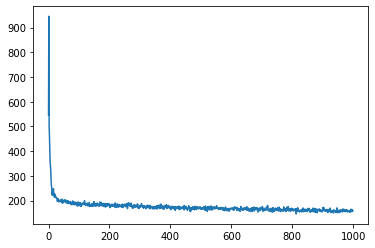

In [17]:
plt.plot(loss1)

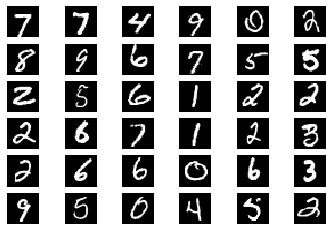

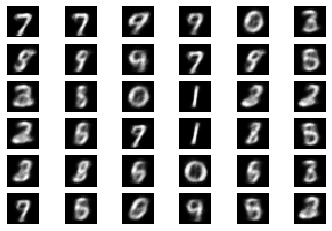

In [24]:
plot_samples(trainX, trainy, W1, b1)

## Checking

### 1.Gradient checking

In [128]:
delta = 0.00001
nBatch = 1 # number of mini-batch to train
M = 1 # batch size
L = 2 # sample size
std_const = 255 # to standardize data

dx = trainX.shape[1] # dimension of the input
dm = 500 # dimension of the hidden layer
dz = 3 # dimension of latent variable

alpha = 0.005 # learning rate

nP = 1000 # print out status every nP batches

Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]

W,b = init_random(dx, dm, dz)
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
eps = np.random.randn(L, dz)
batchX, batchy = get_Batch(M, trainX, trainy)
X = batchX.reshape(M, dx) / std_const

In [129]:
def batch_forward(Spec, X, W, b, eps):
    """forward propagation for one batch"""
    d, M, L, d, d, dm, dz, d, d = Spec
    
    # initialize variables for calculating gradients/ loss by batch
    q_h1 = np.zeros((M, dm))
    q_mu = np.zeros((M, dz))
    q_s2 = np.zeros((M, dz))
    q_a2 = np.zeros((M, dz))
    p_h2 = np.zeros((M, L, dm))
    z = np.zeros((M, L, dz))
    y = np.zeros((M, L, dx))
    
    for iD in range(M):
        q_h1[iD,], q_a2[iD,], q_mu[iD,], q_s2[iD,] = encoder_forward(X[iD,].reshape(-1,1), W, b)

        for iL in range(L):
            z[iD,iL,] = sample_z(q_mu[iD,], q_s2[iD,], eps[iL,])
            y[iD,iL,], p_h2[iD,iL,] = decoder_forward(W, b, z[iD,iL,].reshape(-1,1))
    
    H = [q_h1, p_h2]
    Lt = [q_mu, q_s2, z, eps]
    loss = total_loss(X, y, q_a2, q_mu, q_s2)
    return y, H, Lt, loss

In [130]:
def encoder_forward(X, W, b):
    """
    encoder forward propagation for each data point
    X: dx by 1
    """
    
    q_W1, q_W2, q_W3, d,d = W
    q_b1, q_b2, q_b3, d,d = b
    
    q_a1 = q_W1 @ X + q_b1
    q_h1 = tanh(q_a1)
    q_mu = q_W2 @ q_h1 + q_b2
    q_a2 = q_W3 @ q_h1 + q_b3
    q_s2 = np.exp(q_a2)
    
    return q_h1.T, q_a2.T, q_mu.T, q_s2.T

In [131]:
def sample_z(q_mu, q_s2, eps):
    """sample z"""
    return q_mu + np.sqrt(q_s2) * eps

In [132]:
def decoder_forward(W, b, z):
    """
    decoder forward propagation for each data point and each sample latent variable
    z: dz by 1
    """
    
    d,d,d, p_W4, p_W5 = W
    d,d,d, p_b4, p_b5 = b
    
    p_a3 = p_W4 @ z + p_b4
    p_h2 = tanh(p_a3)
            
    p_a4 = p_W5 @ p_h2 + p_b5
    y = sigmoid(p_a4)
    
    return y.T, p_h2.T

In [133]:
def total_loss(X, y, q_a2, q_mu, q_s2):
    """target total loss function - to minimize"""
    
    M = X.shape[0]
    L = y.shape[1]
    
    loss = 0
    for iD in range(M):
        for iL in range(L):
            # reconstruction loss for each sample of latent variable
            loss = loss - np.sum(X[iD,] * np.log(y[iD,iL,]) + (1-X[iD,]) * np.log(1-y[iD,iL,])) / L
        
        # KL divergence/ regularization
        loss = loss + np.sum(np.power(q_mu[iD,],2) + q_s2[iD,] - q_a2[iD,] - 1)/2
    
    return loss / M

In [134]:
def grad(X, y, W, b, H, Lt):
    """"
    batch gradient
    inputs:
        X: M by dx
        y: M by L by dx
        W: weights
        b: bias
        H: q_h1 (M by dm), p_h2 (M by L by dm)
        Lt: eps (L by dz), z (M by L by dz), q_s2 (M by dz), q_mu (M by dz)
    """
    q_W1, q_W2, q_W3, p_W4, p_W5 = W
    q_b1, q_b2, q_b3, p_b4, p_b5 = b
    q_h1, p_h2 = H
    q_mu, q_s2, z, eps = Lt
    
    M = X.shape[0]
    L = y.shape[1]
    
    # initialize gradient variables
    
    # L: loss; R: regularization; J: total target
    dL_dW1 = dJ_dW1 = dR_dW1 = np.zeros_like(q_W1)
    dL_db1 = dJ_db1 = dR_db1 = np.zeros_like(q_b1)
    dL_dW2 = dJ_dW2 = dR_dW2 = np.zeros_like(q_W2)
    dL_db2 = dJ_db2 = dR_db2 = np.zeros_like(q_b2)
    dL_dW3 = dJ_dW3 = dR_dW3 = np.zeros_like(q_W3)
    dL_db3 = dJ_db3 = dR_db3 = np.zeros_like(q_b3)
    dL_dW4 = dJ_dW4 = np.zeros_like(p_W4)
    dL_db4 = dJ_db4 = np.zeros_like(p_b4)    
    dL_dW5 = dJ_dW5 = np.zeros_like(p_W5)
    dL_db5 = dJ_db5 = np.zeros_like(p_b5)
    
    for iD in range(M):
        for iL in range(L):
            # back propagation for loss

            #L_d4 = (np.divide(y[iD,iL,]-X[iD,], y[iD,iL,] * (1-y[iD,iL,])) * sigmoid_gradient(y[iD,iL,])).reshape(-1,1)
            
            # simplied L_d4
            L_d4 = (y[iD,iL,]-X[iD,]).reshape(-1,1)
            dL_dW5 = dL_dW5 + L_d4 @ p_h2[iD,iL,].reshape(1,-1)
            dL_db5 = dL_db5 + L_d4
            
            L_d3 = p_W5.T @ L_d4 * tanh_gradient(p_h2[iD,iL,]).reshape(-1,1)
            dL_dW4 = dL_dW4 + L_d3 @ z[iD,iL,].reshape(1,-1)
            dL_db4 = dL_db4 + L_d3
            
            L_d22 = p_W4.T @ L_d3 * eps[iL,].reshape(-1,1) * np.sqrt(q_s2[iD,]).reshape(-1,1) / 2
            dL_dW3 = dL_dW3 + L_d22 @ q_h1[iD,].reshape(1,-1)
            dL_db3 = dL_db3 + L_d22
            
            L_d21 = p_W4.T @ L_d3
            dL_dW2 = dL_dW2 + L_d21 @ q_h1[iD,].reshape(1,-1)
            dL_db2 = dL_db2 + L_d21
            
            L_d1 = (q_W2.T @ L_d21 + q_W3.T @ L_d22) * tanh_gradient(q_h1[iD,]).reshape(-1,1)
            dL_dW1 = dL_dW1 + L_d1 @ X[iD,].reshape(1,-1)
            dL_db1 = dL_db1 + L_d1
        
        # back propagation for regularization
        R_d22 = ((q_s2[iD,]-1)/2).reshape(-1,1)
        dR_dW3 = dR_dW3 + R_d22 @ q_h1[iD,].reshape(1,-1)
        dR_db3 = dR_db3 + R_d22

        R_d21 = q_mu[iD,].reshape(-1,1)
        dR_dW2 = dR_dW2 + R_d21 @ q_h1[iD,].reshape(1,-1)
        dR_db2 = dR_db2 + R_d21

        R_d1 = (q_W3.T @ R_d22 + q_W2.T @ R_d21) * tanh_gradient(q_h1[iD,]).reshape(-1,1)
        dR_dW1 = dR_dW1 + R_d1 @ X[iD,].reshape(1,-1)
        dR_db1 = dR_db1 + R_d1
    
    dJ_dW1 = dL_dW1 / L / M + dR_dW1 / M
    dJ_db1 = dL_db1 / L / M + dR_db1 / M
    dJ_dW2 = dL_dW2 / L / M + dR_dW2 / M
    dJ_db2 = dL_db2 / L / M + dR_db2 / M    
    dJ_dW3 = dL_dW3 / L / M + dR_dW3 / M
    dJ_db3 = dL_db3 / L / M + dR_db3 / M
    dJ_dW4 = dL_dW4 / L / M
    dJ_db4 = dL_db4 / L / M 
    dJ_dW5 = dL_dW5 / L / M
    dJ_db5 = dL_db5 / L / M
    
    dW = [dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5]
    db = [dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5]
    
    return dW, db

In [135]:
y, H, Lt, loss1 = batch_forward(Spec, X, W, b, eps)
q_h1, p_h2 = H
q_mu, q_s2, z, eps = Lt

In [136]:
dL_dW1, dL_dW2, dL_dW3, dL_dW4, dL_dW5, dL_db1, dL_db2, dL_db3, dL_db4, dL_db5 =\
grad_vec2_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)

ValueError: unable to broadcast argument 1 to output array
File "<ipython-input-108-67141a914759>", line 49, 

In [29]:
# gradient checking
p_W5_add = p_W5 + delta
p_W5_red = p_W5 - delta

p_b5_add = p_b5 + delta
p_b5_red = p_b5 - delta

p_W4_add = p_W4 + delta
p_W4_red = p_W4 - delta

p_b4_add = p_b4 + delta
p_b4_red = p_b4 - delta

q_W3_add = q_W3 + delta
q_W3_red = q_W3 - delta

q_b3_add = q_b3 + delta
q_b3_red = q_b3 - delta

q_W2_add = q_W2 + delta
q_W2_red = q_W2 - delta

q_b2_add = q_b2 + delta
q_b2_red = q_b2 - delta

q_W1_add = q_W1 + delta
q_W1_red = q_W1 - delta

q_b1_add = q_b1 + delta
q_b1_red = q_b1 - delta

W5_add = [q_W1, q_W2, q_W3, p_W4, p_W5_add]
W5_red = [q_W1, q_W2, q_W3, p_W4, p_W5_red]

b5_add = [q_b1, q_b2, q_b3, p_b4, p_b5_add]
b5_red = [q_b1, q_b2, q_b3, p_b4, p_b5_red]

W4_add = [q_W1, q_W2, q_W3, p_W4_add, p_W5]
W4_red = [q_W1, q_W2, q_W3, p_W4_red, p_W5]

b4_add = [q_b1, q_b2, q_b3, p_b4_add, p_b5]
b4_red = [q_b1, q_b2, q_b3, p_b4_red, p_b5]

W3_add = [q_W1, q_W2, q_W3_add, p_W4, p_W5]
W3_red = [q_W1, q_W2, q_W3_red, p_W4, p_W5]

b3_add = [q_b1, q_b2, q_b3_add, p_b4, p_b5]
b3_red = [q_b1, q_b2, q_b3_red, p_b4, p_b5]

W2_add = [q_W1, q_W2_add, q_W3, p_W4, p_W5]
W2_red = [q_W1, q_W2_red, q_W3, p_W4, p_W5]

b2_add = [q_b1, q_b2_add, q_b3, p_b4, p_b5]
b2_red = [q_b1, q_b2_red, q_b3, p_b4, p_b5]

W1_add = [q_W1_add, q_W2, q_W3, p_W4, p_W5]
W1_red = [q_W1_red, q_W2, q_W3, p_W4, p_W5]

b1_add = [q_b1_add, q_b2, q_b3, p_b4, p_b5]
b1_red = [q_b1_red, q_b2, q_b3, p_b4, p_b5]

d,d,d,loss_W5_add = batch_forward(Spec, X, W5_add, b, eps)
d,d,d,loss_W5_red = batch_forward(Spec, X, W5_red, b, eps)

d,d,d,loss_b5_add = batch_forward(Spec, X, W, b5_add, eps)
d,d,d,loss_b5_red = batch_forward(Spec, X, W, b5_red, eps)

d,d,d,loss_W4_add = batch_forward(Spec, X, W4_add, b, eps)
d,d,d,loss_W4_red = batch_forward(Spec, X, W4_red, b, eps)

d,d,d,loss_b4_add = batch_forward(Spec, X, W, b4_add, eps)
d,d,d,loss_b4_red = batch_forward(Spec, X, W, b4_red, eps)

d,d,d,loss_W3_add = batch_forward(Spec, X, W3_add, b, eps)
d,d,d,loss_W3_red = batch_forward(Spec, X, W3_red, b, eps)

d,d,d,loss_b3_add = batch_forward(Spec, X, W, b3_add, eps)
d,d,d,loss_b3_red = batch_forward(Spec, X, W, b3_red, eps)

d,d,d,loss_W2_add = batch_forward(Spec, X, W2_add, b, eps)
d,d,d,loss_W2_red = batch_forward(Spec, X, W2_red, b, eps)

d,d,d,loss_b2_add = batch_forward(Spec, X, W, b2_add, eps)
d,d,d,loss_b2_red = batch_forward(Spec, X, W, b2_red, eps)

d,d,d,loss_W1_add = batch_forward(Spec, X, W1_add, b, eps)
d,d,d,loss_W1_red = batch_forward(Spec, X, W1_red, b, eps)

d,d,d,loss_b1_add = batch_forward(Spec, X, W, b1_add, eps)
d,d,d,loss_b1_red = batch_forward(Spec, X, W, b1_red, eps)

print("var", "manual", "grad func")
print("W5: ", (loss_W5_add - loss_W5_red)/2/delta, np.sum(dL_dW5))
print("b5: ", (loss_b5_add - loss_b5_red)/2/delta, np.sum(dL_db5))
print("W4: ", (loss_W4_add - loss_W4_red)/2/delta, np.sum(dL_dW4))
print("b4: ", (loss_b4_add - loss_b4_red)/2/delta, np.sum(dL_db4))
print("W3: ", (loss_W3_add - loss_W3_red)/2/delta, np.sum(dL_dW3))
print("b3: ", (loss_b3_add - loss_b3_red)/2/delta, np.sum(dL_db3))
print("W2: ", (loss_W2_add - loss_W2_red)/2/delta, np.sum(dL_dW2))
print("b2: ", (loss_b2_add - loss_b2_red)/2/delta, np.sum(dL_db2))
print("W1: ", (loss_W1_add - loss_W1_red)/2/delta, np.sum(dL_dW1))
print("b1: ", (loss_b1_add - loss_b1_red)/2/delta, np.sum(dL_db1))

var manual grad func
W5:  742.0446729668128 742.0446729570698
b5:  297.2612658709295 297.2612658696403
W4:  15.756503574948509 15.75650358300687
b4:  -8.287481102797756 -8.287481116570488
W3:  5.787541698509812 5.787541682365959
b3:  1.800083208536307 1.8000831970383162
W2:  -8.895183037793686 -8.895183020498987
b2:  -3.4511241267409782 -3.451124101918673
W1:  -352.4493544034612 -352.4495336590897
b1:  -3.7860770135011985 -3.7860770110999162


### 2. Functions checking

#### 2.1 batch_forward_vec_nb2

In [30]:
nBatch = 1 # number of mini-batch to train
M = 100 # batch size
L = 2 # sample size
std_const = 255 # to standardize data

Xdim1, Xdim2 = trainX[0].shape[0], trainX[0].shape[1]
dx = Xdim1 * Xdim2 # dimension of the input
dm = 500 # dimension of the hidden layer
dz = 3 # dimension of latent variable

alpha = 0.005 # learning rate

nP = 1000 # print out status every nP batches

Spec = [nBatch, M, L, std_const, dx, dm, dz, alpha, nP]

W,b = init_random(dx, dm, dz)
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
eps = np.random.randn(L, dz)
batchX, batchy = get_Batch(M, trainX, trainy)
X = batchX.reshape(M, dx) / std_const

In [31]:
y_original, H_original, Lt_original, loss_original = batch_forward(Spec, X, W, b, eps)
q_h1_original, p_h2_original = H_original
q_mu_original, q_s2_original, z_original, eps_original = Lt_original

In [32]:
y_new, q_h1_new, p_h2_new, q_mu_new, q_s2_new, z_new, loss_new = batch_forward_vec_nb2(Spec, X, W, b, eps)

In [33]:
print(np.allclose(y_original, y_new))
print(np.allclose(q_h1_original, q_h1_new))
print(np.allclose(p_h2_original, p_h2_new))
print(np.allclose(q_mu_original, q_mu_new))
print(np.allclose(q_s2_original, q_s2_new))
print(np.allclose(z_original, z_new))
print(np.allclose(loss_original, loss_new))

True
True
True
True
True
True
True


#### 2.2 grad_vec2_nb2

In [36]:
y, H, Lt, loss = batch_forward(Spec, X, W, b, eps)
dW_ori, db_ori = grad(X, y, W, b, H, Lt)

In [37]:
nBatch, M, L, std_const, dx, dm, dz, alpha, nP = Spec
q_W1, q_W2, q_W3, p_W4, p_W5 = W
q_b1, q_b2, q_b3, p_b4, p_b5 = b
q_h1, p_h2 = H
q_mu, q_s2, z, eps = Lt
dJ_dW1, dJ_dW2, dJ_dW3, dJ_dW4, dJ_dW5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5 = \
grad_vec2_nb2(X, y, q_W1, q_W2, q_W3, p_W4, p_W5, q_b1, q_b2, q_b3, p_b4, p_b5, q_h1, p_h2, q_mu, q_s2, z, eps)

In [38]:
print(np.allclose(dW_ori[0], dJ_dW1))
print(np.allclose(dW_ori[1], dJ_dW2))
print(np.allclose(dW_ori[2], dJ_dW3))
print(np.allclose(dW_ori[3], dJ_dW4))
print(np.allclose(dW_ori[4], dJ_dW5))

print(np.allclose(db_ori[0], dJ_db1))
print(np.allclose(db_ori[1], dJ_db2))
print(np.allclose(db_ori[2], dJ_db3))
print(np.allclose(db_ori[3], dJ_db4))
print(np.allclose(db_ori[4], dJ_db5))

True
True
True
True
True
True
True
True
True
True


In [25]:
from scipy.io import loadmat
caltech = loadmat('caltech101_silhouettes_16.mat')

In [26]:
caltech.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y', 'classnames'])

In [27]:
calX = caltech['X']
caly = caltech['Y'].reshape(-1,1)

In [30]:
W,b,loss = train_AEVB(calX, caly, 10000, dm=128, std_const = 1, W=W, b=b, loss=loss)

<ipython-input-19-e991170f6e2f>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "train_AEVB" failed type inference due to: Use of unsupported NumPy function 'numpy.resize' or unsupported use of the function.

File "<ipython-input-19-e991170f6e2f>", line 93:
def train_AEVB(trainX, trainy, nBatch, M = 100, L = 1, std_const = 255, dm = 500, dz = 3, alpha = 0.005, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8, W = "", b = "", loss = "", nP = 0):
    <source elided>
    else:
        loss = np.resize(loss, start + nBatch)
        ^

[1] During: typing of get attribute at <ipython-input-19-e991170f6e2f> (93)

File "<ipython-input-19-e991170f6e2f>", line 93:
def train_AEVB(trainX, trainy, nBatch, M = 100, L = 1, std_const = 255, dm = 500, dz = 3, alpha = 0.005, beta1 = 0.9, beta2 = 0.999, eps_stable = 1e-8, W = "", b = "", loss = "", nP = 0):
    <source elided>
    else:
        loss = np.resize(loss, start + nBatch)
        ^

  @jit(ca

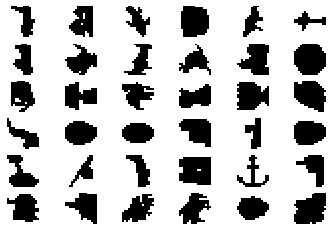

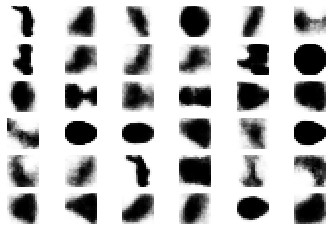

In [31]:
plot_samples(calX, caly, W, b, std_const = 1)

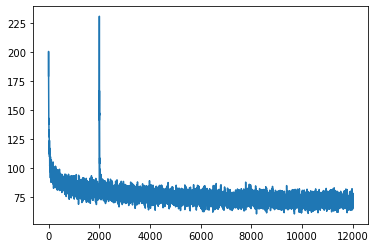

In [32]:
plt.plot(loss)

In [47]:
def save_para(filename, **kwargs):
    """save weights and bias parameters"""
    file = open(filename, 'wb')
    pickle.dump(kwargs, file)
    file.close()

In [49]:
import pickle
filename = "2020_04_30_22_41_05_Model_v1.3_parameter_Caltech"
doc = "model run for Caltech data, 80000 iterations"
save_para(filename, doc = doc, W = W, b = b, loss = loss)